<a href="https://colab.research.google.com/github/NL364/Time-Series/blob/main/notebooks/tf2/time-series-rnn-full-predict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Forecasting Time Series data

* Idea and some code taken from, and also OPSD time series data set explained here: https://www.dataquest.io/blog/tutorial-time-series-analysis-with-pandas/
* Some code and approaches from: https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/
* Nice tutorial: https://www.tensorflow.org/beta/tutorials/text/time_series

In [30]:
%matplotlib inline

import matplotlib.pyplot as plt
# plt.xkcd()
# plt.style.use('ggplot')
%matplotlib inline

import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (20, 8)

In [31]:
import pandas as pd
import numpy as np

In [32]:
# for local
# url = 'Monthly_Readings.csv'

# for colab
url = 'https://raw.githubusercontent.com/NL364/Time-Series/main/Monthly%20Readings%202012-2022%20(08-11-23).csv'

time_series_df = pd.read_csv(url,
                             sep=',',
                             index_col=0, # you can use the date as the index for pandas
                             parse_dates=['Date'], dayfirst=True)

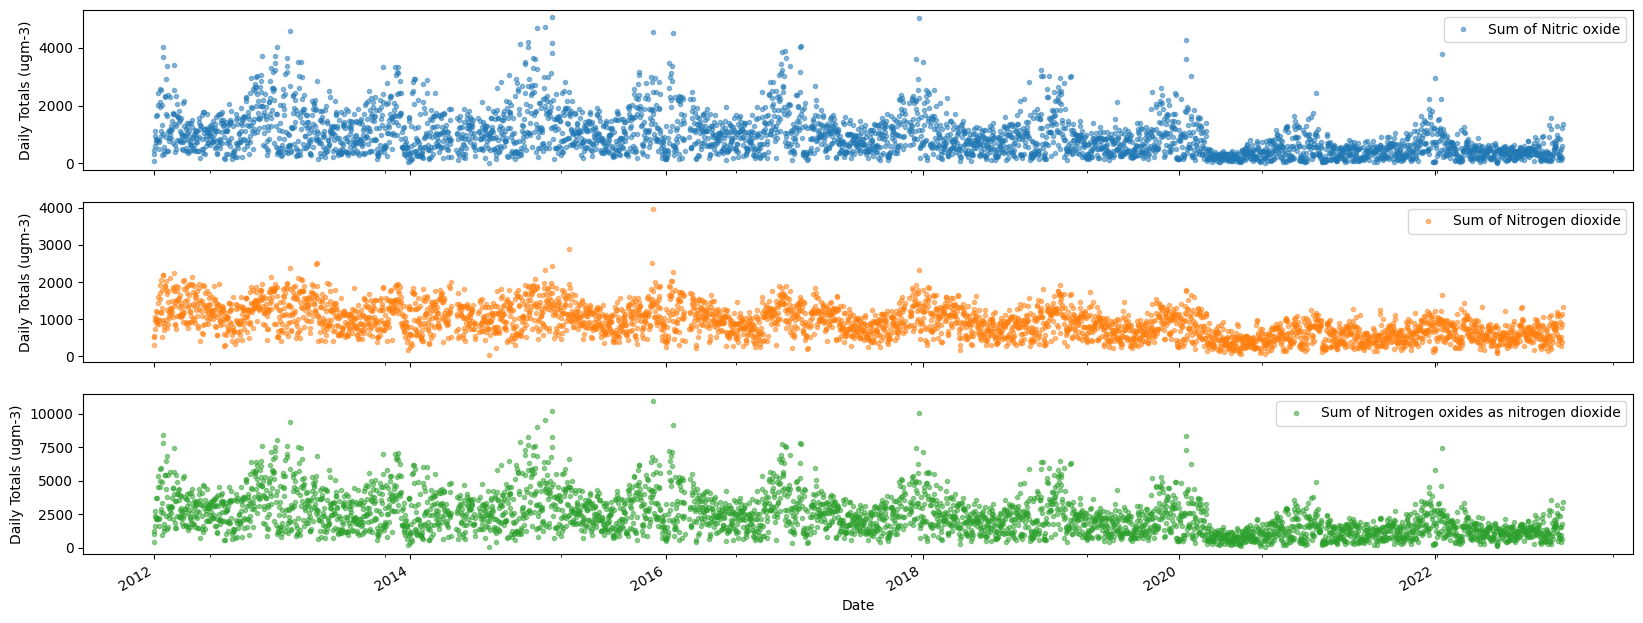

In [33]:
cols_plot = ['Sum of Nitric oxide', 'Sum of Nitrogen dioxide', 'Sum of Nitrogen oxides as nitrogen dioxide']

axes = time_series_df[cols_plot].plot(marker='.', alpha=0.5, linestyle='None', subplots=True)
for ax in axes:
    ax.set_ylabel('Daily Totals (ugm-3)')

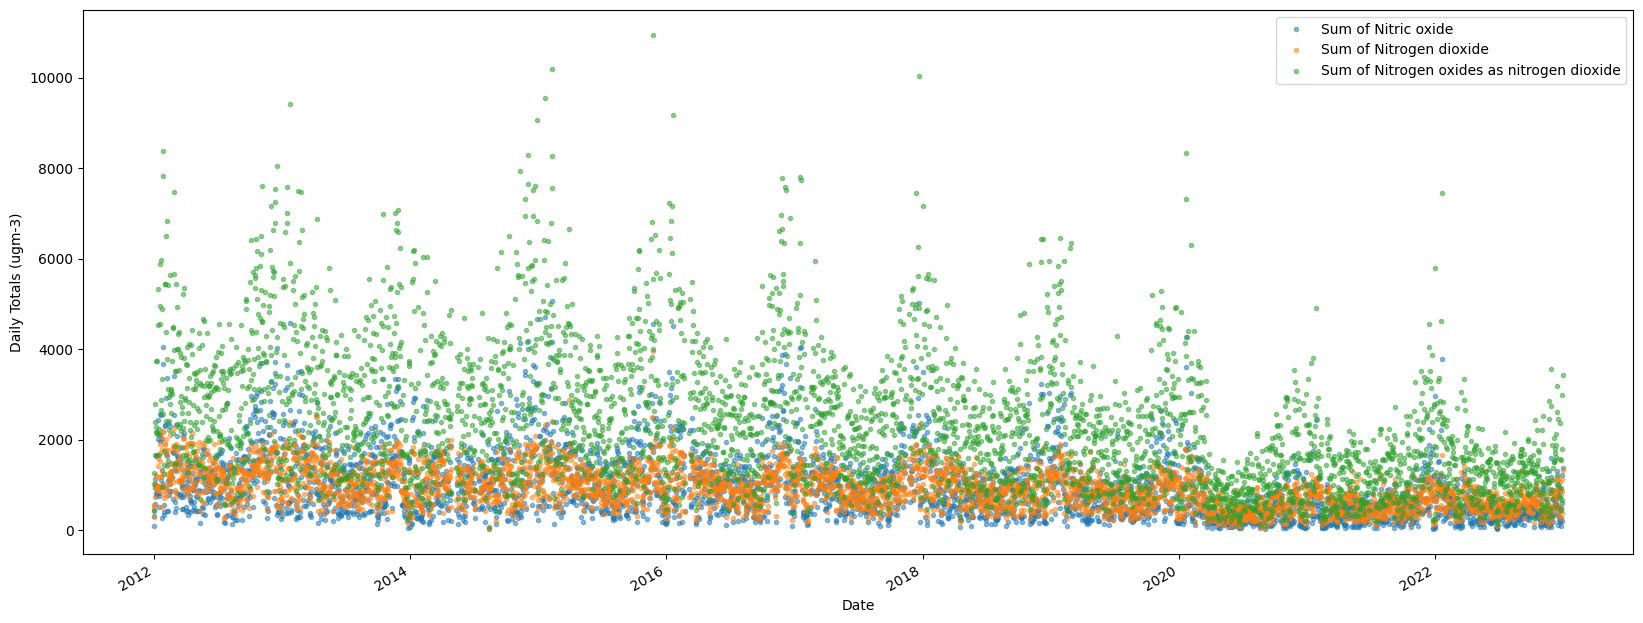

In [34]:
axes = time_series_df.plot(marker='.', alpha=0.5, linestyle='None')
plt.ylabel('Daily Totals (ugm-3)');


## Can we predict each day's consumption from its past?

### We train on the years 2006 - 2016 and validate on 2017

In [72]:
NO = time_series_df['Sum of Nitric oxide'].to_numpy()
NO.shape

(3959,)

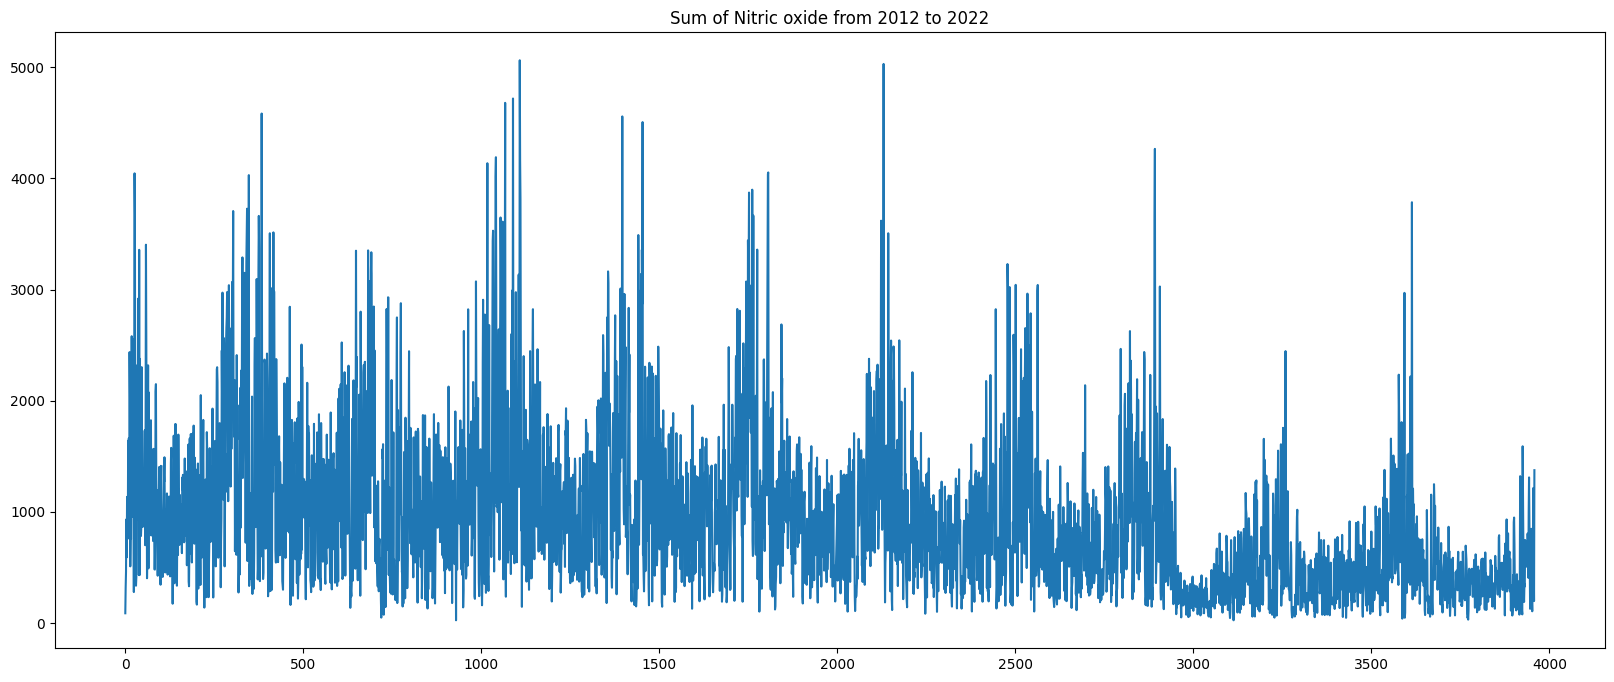

In [75]:
plt.title('Sum of Nitric oxide from 2012 to 2022')
plt.plot(NO);

## Statistical Methods directly geared towards forecasting

_Statistical Methods are often favorable: https://twitter.com/togelius/status/1173272424177119233_

* https://machinelearningmastery.com/time-series-forecasting-methods-in-python-cheat-sheet/
* https://towardsdatascience.com/an-end-to-end-project-on-time-series-analysis-and-forecasting-with-python-4835e6bf050b#targetText=Time%20series%20forecasting%20is%20the,forecasting%20retail%20sales%20time%20series.
* https://www.dataquest.io/blog/tutorial-time-series-analysis-with-pandas/
* https://research.fb.com/prophet-forecasting-at-scale/

https://www.statsmodels.org
* https://www.statsmodels.org/stable/examples/index.html#stats
* https://www.statsmodels.org/stable/examples/notebooks/generated/tsa_arma_0.html
* https://www.statsmodels.org/stable/tsa.html



<ipython-input-78-bcab1505b761>:3: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  decomposition = sm.tsa.seasonal_decompose(time_series_df['2022']['Sum of Nitric oxide'], model='additive')


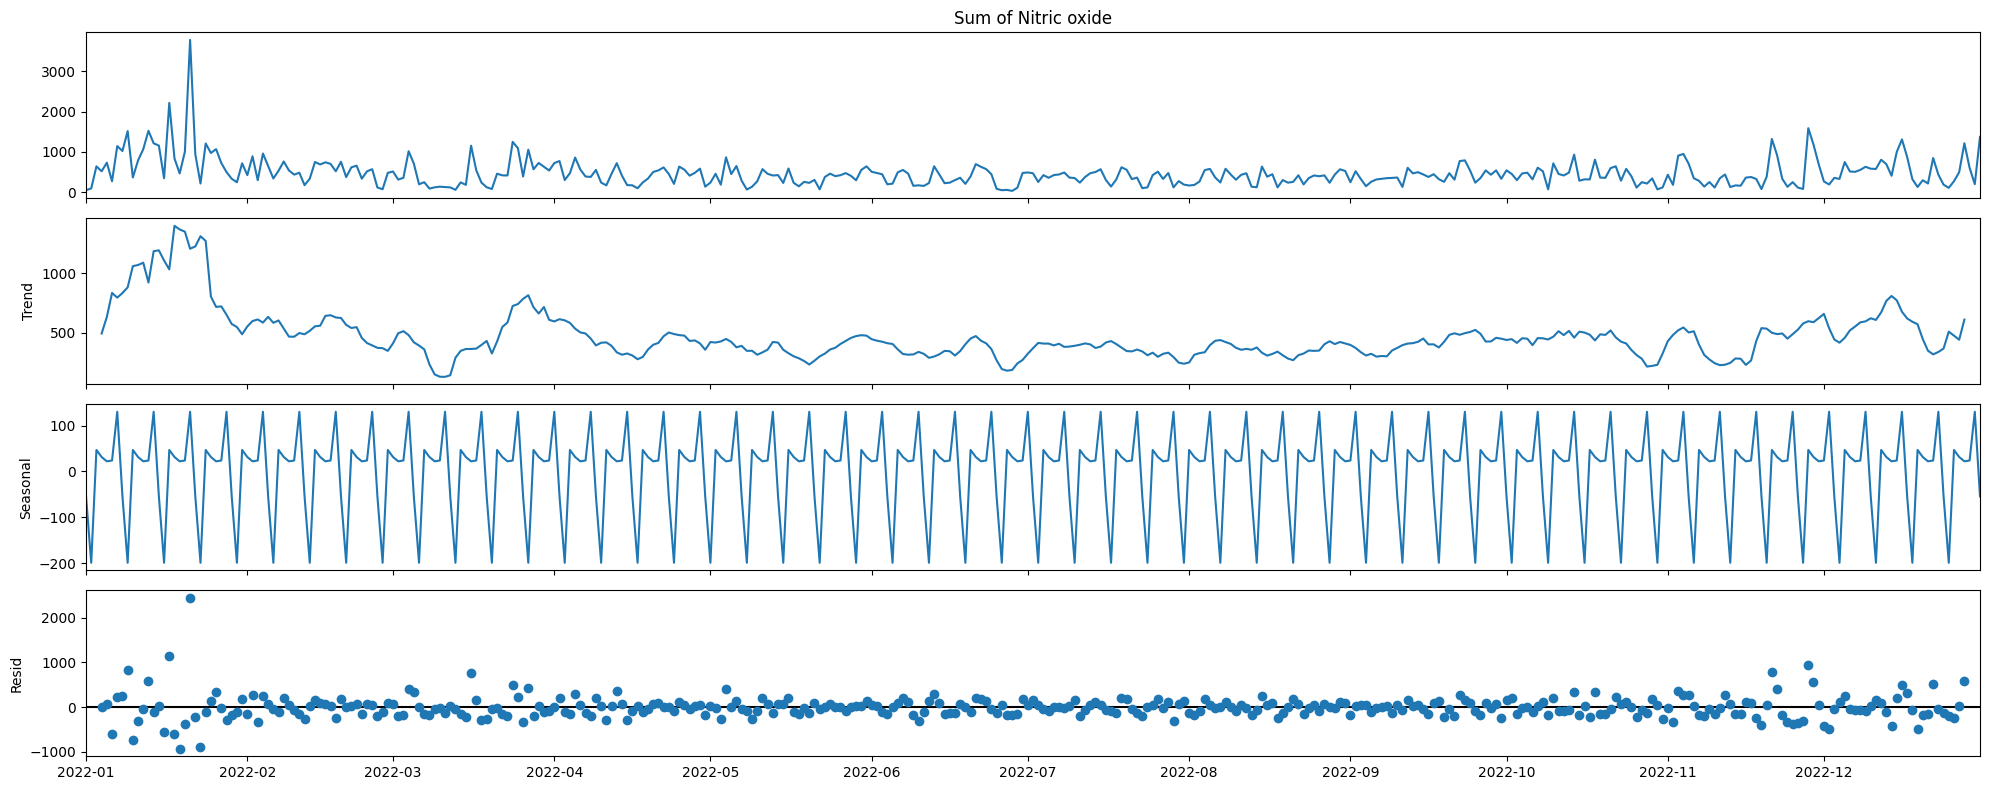

In [78]:
import statsmodels.api as sm

decomposition = sm.tsa.seasonal_decompose(time_series_df['2022']['Sum of Nitric oxide'], model='additive')
decomposition.plot();

In [79]:
# derived from here: https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/

# split a univariate sequence into samples
def split_sequence(sequence, n_steps_in, n_steps_out):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps_in
		out_end_ix = end_ix + n_steps_out
		# check if we are beyond the sequence
		if out_end_ix > len(sequence):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)

### How much of the past would we like for each individual prediction?

In [39]:
#@title Prediction from n past days

# https://colab.research.google.com/notebooks/forms.ipynb

n_steps_in = 30 #@param {type:"slider", min:1, max:100, step:1}
n_steps_out = 1

In [40]:
X, Y = split_sequence(NO, n_steps_in, n_steps_out)
X.shape, Y.shape

((3929, 30), (3929, 1))

In [41]:
X[0], Y[0]

(array([  88,  318,  461,  933,  591, 1135,  833,  759, 1641,  814, 1664,
         818, 2437, 2026,  510,  815,  757, 1966, 2580, 2116, 1107,  958,
        2550, 1331,  279, 2018, 4045, 3677, 1033,  565]),
 array([336]))

In [42]:
# reshape from [samples, timesteps] to [samples, timesteps, features]
n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))
X.shape

(3929, 30, 1)

In [43]:
# we do a special test / train split,
# we see how well we can predict 2017 as test/validation


X_train = X[:-365]
Y_train = Y[:-365]

X_test = X[-365:]
Y_test = Y[-365:]

X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

((3564, 30, 1), (3564, 1), (365, 30, 1), (365, 1))

## Baslines

### R2 Metric: MSE and MAE are not speaking

* R^2 score, the closer to 1 the better
* loosely speaking: how much better is this than predicting the constant mean
* 0 would mean just as good
* 1 is perfect
* neg. would mean even worse
* it can become arbitrarily worse

https://en.wikipedia.org/wiki/Coefficient_of_determination


### Rolling mean baseline

In [44]:
def rolling_mean_baseline(history):
  return np.mean(history, axis=1)

In [45]:
Y_pred_baseline_rolling = rolling_mean_baseline(X)
Y_pred_baseline_rolling.shape

(3929, 1)

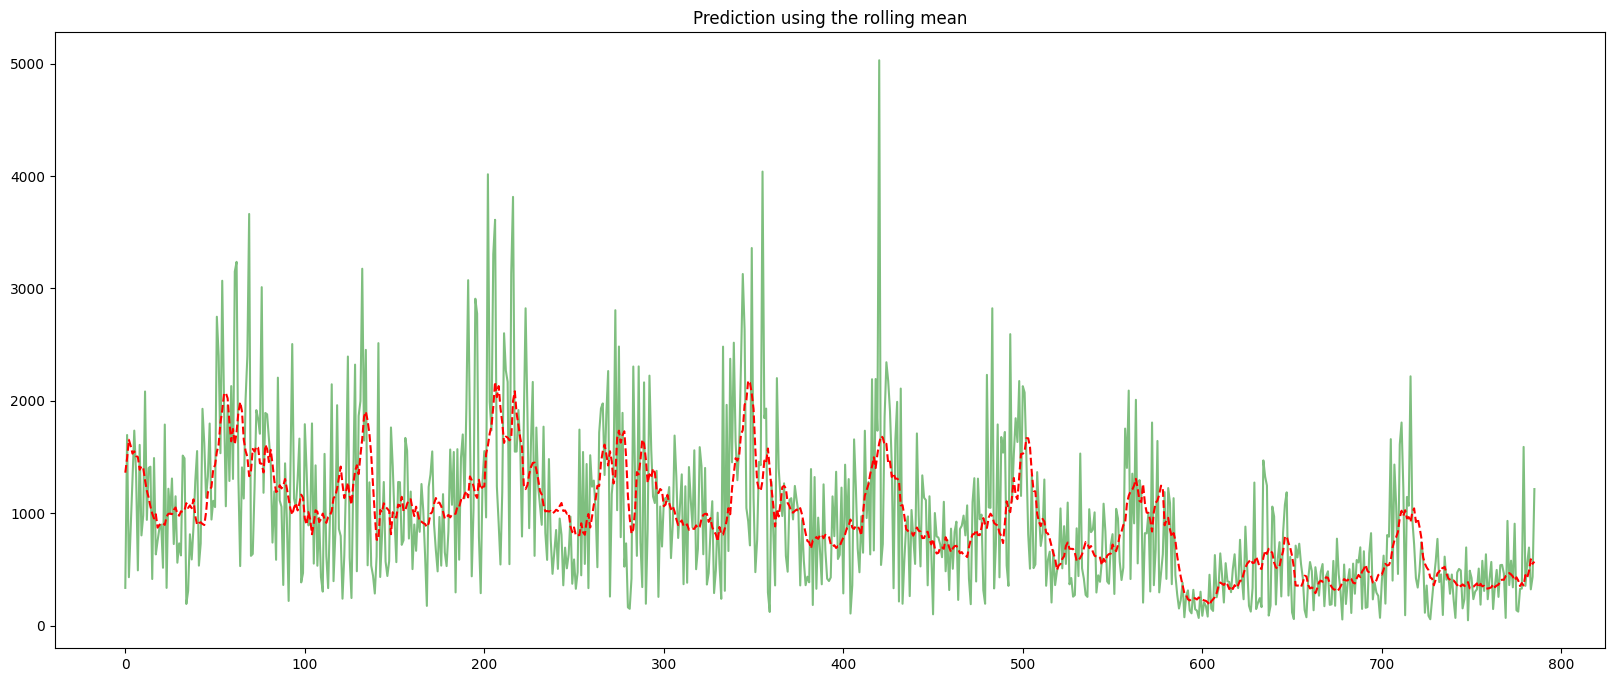

In [46]:
# this gets really crowded, using a stride, makes it more readable
stride = 5


plt.plot(NO[n_steps_in::stride], alpha=0.5, color='g')
plt.plot(Y_pred_baseline_rolling[::stride], color='r', ls='dashed')

plt.title('Prediction using the rolling mean');


In [47]:
from sklearn.metrics import r2_score

r2_score(Y, Y_pred_baseline_rolling)


0.2565106165457882

### Baseline: Previous Value

In [48]:
def previous_value_baseline(history):
  return history[:, -1]

In [49]:
Y_pred_baseline_previous_value = previous_value_baseline(X)
Y_pred_baseline_previous_value.shape

(3929, 1)

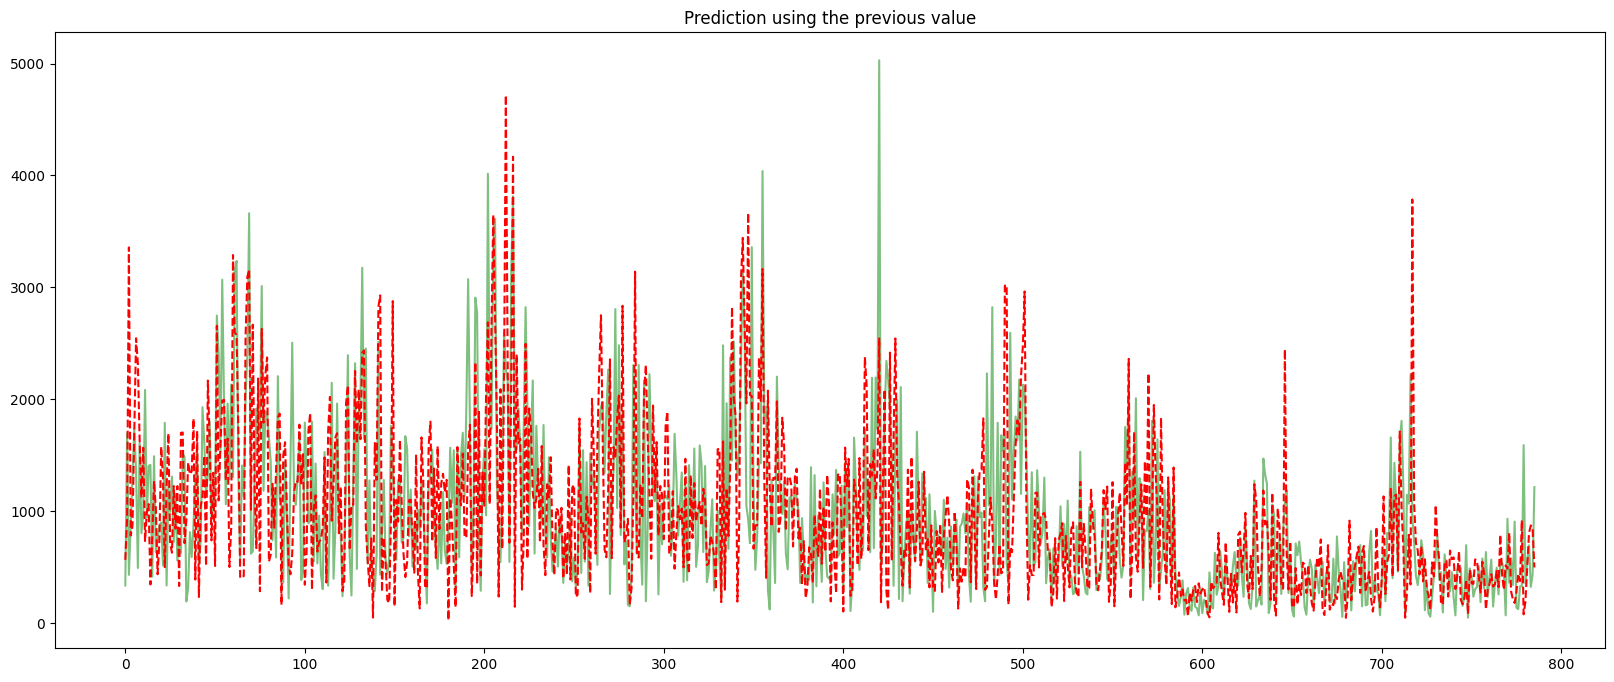

In [50]:
# this gets really crowded, using a stride, makes it more readable
stride = 5


plt.plot(NO[n_steps_in::stride], alpha=0.5, color='g')
plt.plot(Y_pred_baseline_previous_value[::stride], color='r', ls='dashed')
plt.title('Prediction using the previous value');

### This looks good at first sight, but wait for the R2 score

It is (obviously) always off by one

In [51]:
from sklearn.metrics import r2_score


# Define nan_mask to identify NaN values in your data
nan_mask = np.isnan(Y) | np.isnan(Y_pred_baseline_previous_value)

# Handle NaN values
Y = np.where(nan_mask, np.nan, Y)
Y_pred_baseline_previous_value = np.where(nan_mask, np.nan, Y_pred_baseline_previous_value)

# Calculate R-squared, ignoring NaN values
r2 = r2_score(Y[~nan_mask], Y_pred_baseline_previous_value[~nan_mask])
print("R-squared score:", r2)




R-squared score: 0.06097364643671399


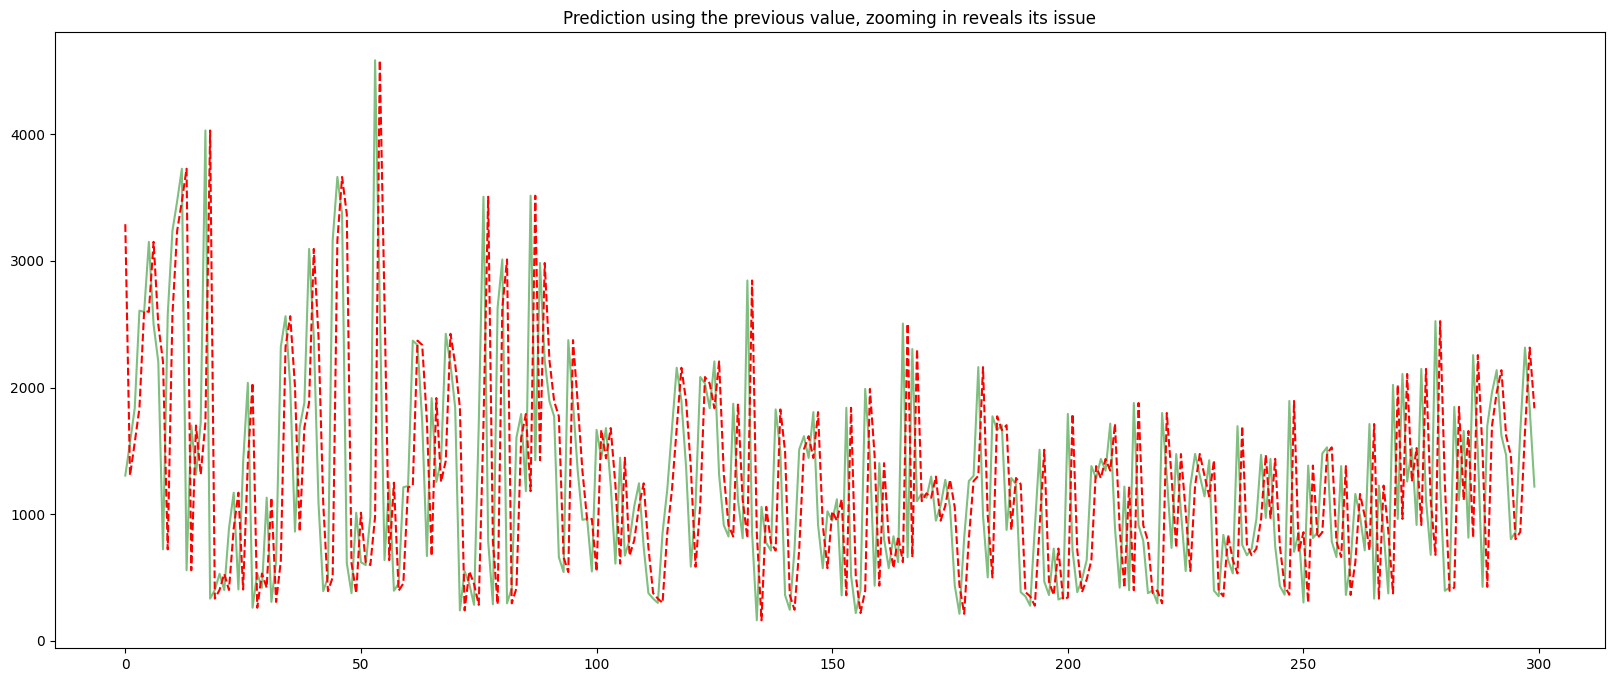

In [52]:
# this gets really crowded, using a stride, makes it more readable
stride = 1
# too crwoded, zoom in
window_start = 300
window_end = 600

plt.plot(NO[n_steps_in+window_start:n_steps_in+window_end:stride], alpha=0.5, color='g')
plt.plot(Y_pred_baseline_previous_value[window_start:window_end:stride], color='r', ls='dashed')

plt.title('Prediction using the previous value, zooming in reveals its issue');

## Prediction using RNNs and TensorFlow

### Can we beat an r2 score around .20?

In [53]:
# Gives us a well defined version of tensorflow

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [54]:
import tensorflow as tf
print(tf.__version__)

2.14.0


### Just for the reference, what GPU are we running on?

In [55]:
# What kind of GPU are we running on
!nvidia-smi

Wed Nov  8 21:49:04 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   65C    P0    29W /  70W |    609MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [56]:
# adapted from https://stackoverflow.com/a/42351397/1756489 and ported to TF 2
# https://keras.io/metrics/#custom-metrics

# only works on tensors while training, use sklearn version when using on numpy arrays

def r2_metric(y_true, y_pred):
  total_error = tf.reduce_sum(tf.square(tf.subtract(y_true, tf.reduce_mean(y_true))))
  unexplained_error = tf.reduce_sum(tf.square(tf.subtract(y_true, y_pred)))
  R_squared = tf.subtract(1.0, tf.divide(unexplained_error, total_error))

  return R_squared

### Training our model

In [172]:
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from tensorflow.keras.layers import Dense, SimpleRNN
from tensorflow.keras.models import Sequential

# Load your time series data
# ...

# Assuming your DataFrame is named time_series_df
features = ['Sum of Nitric oxide', 'Sum of Nitric oxide']
target_variable = 'Sum of Nitric oxide'

# Select features and target variable
X = time_series_df[features]
y = time_series_df[target_variable]

# Split the data into training and validation sets
X_train, X_val, Y_train, Y_val = train_test_split(X, y, test_size=0.2, shuffle=False)

# Normalize the data
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# Reshape the input data to include a time step dimension
X_train_reshaped = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_val_reshaped = X_val_scaled.reshape((X_val_scaled.shape[0], 1, X_val_scaled.shape[1]))

# Model definition
model = Sequential()
model.add(SimpleRNN(256, activation='relu', return_sequences=True, input_shape=(1, X_train_scaled.shape[1])))
model.add(SimpleRNN(128, activation='relu'))
model.add(Dense(1))  # Output layer with 1 neuron for regression
model.compile(optimizer='adam', loss='mse', metrics=[r2_metric])

model.summary()








Model: "sequential_38"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_55 (SimpleRNN)   (None, 1, 256)            66304     
                                                                 
 simple_rnn_56 (SimpleRNN)   (None, 128)               49280     
                                                                 
 dense_34 (Dense)            (None, 1)                 129       
                                                                 
Total params: 115713 (452.00 KB)
Trainable params: 115713 (452.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [173]:
%%time

batch_size = 32

history = model.fit(X_train_reshaped, Y_train, validation_data=(X_val_reshaped, Y_val), epochs=25, callbacks=[early_stopping])


Epoch 1/25
99/99 [==============================] - 3s 13ms/step - loss: 1644656.5000 - r2_metric: -2.2784 - val_loss: 353671.7188 - val_r2_metric: -2.9378
Epoch 2/25
99/99 [==============================] - 1s 13ms/step - loss: 1280842.6250 - r2_metric: -1.5807 - val_loss: 143299.4531 - val_r2_metric: -0.1310
Epoch 3/25
99/99 [==============================] - 1s 9ms/step - loss: 498543.4375 - r2_metric: 0.0226 - val_loss: 177842.0000 - val_r2_metric: -2.4169
Epoch 4/25
99/99 [==============================] - 1s 7ms/step - loss: 225644.2812 - r2_metric: 0.5653 - val_loss: 227960.2188 - val_r2_metric: -3.6113
Epoch 5/25
99/99 [==============================] - 1s 7ms/step - loss: 184938.5312 - r2_metric: 0.6419 - val_loss: 195202.9844 - val_r2_metric: -2.9601
Epoch 6/25
99/99 [==============================] - 1s 7ms/step - loss: 147698.2031 - r2_metric: 0.7069 - val_loss: 154582.2969 - val_r2_metric: -2.1410
Epoch 7/25
99/99 [==============================] - 1s 8ms/step - loss: 1104

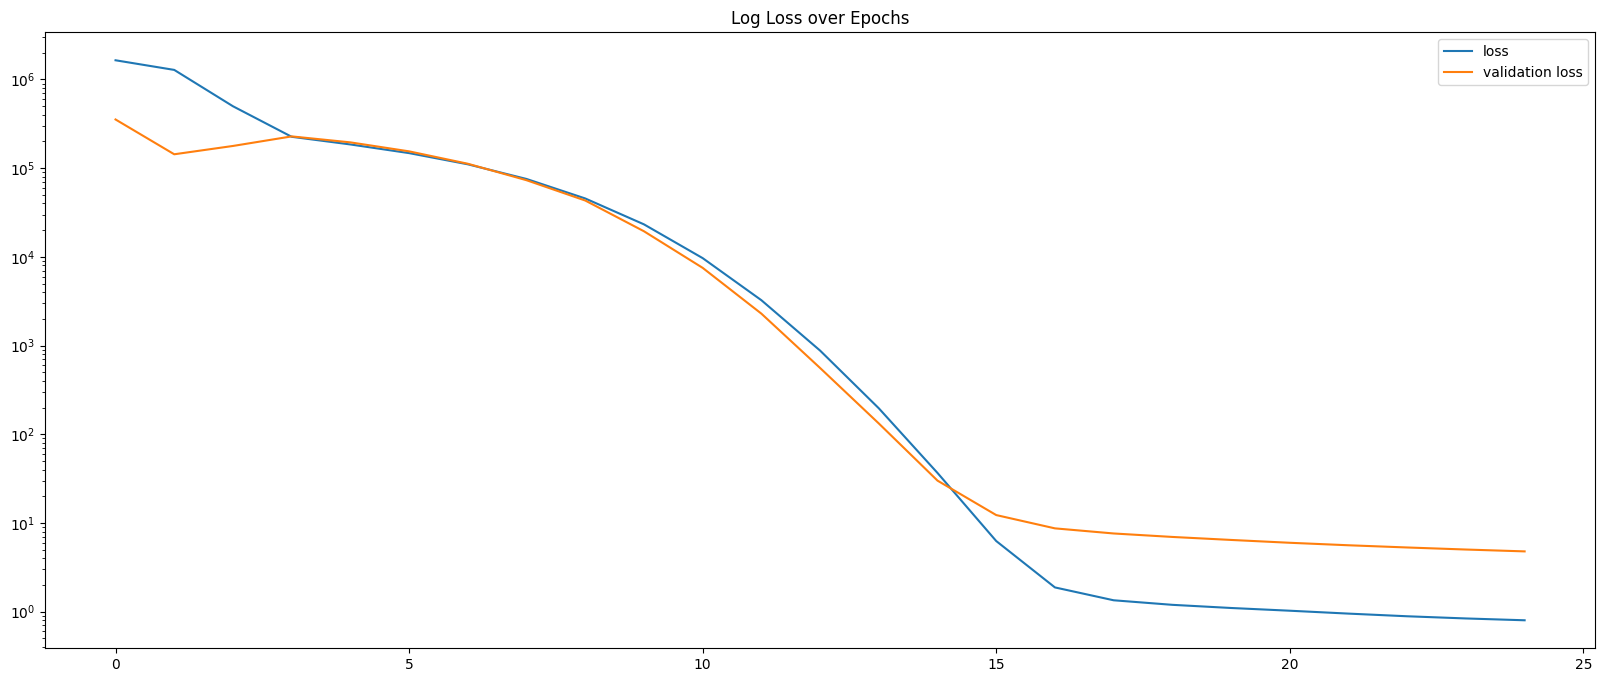

In [174]:
plt.yscale('log')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Log Loss over Epochs')

plt.legend(['loss', 'validation loss']);

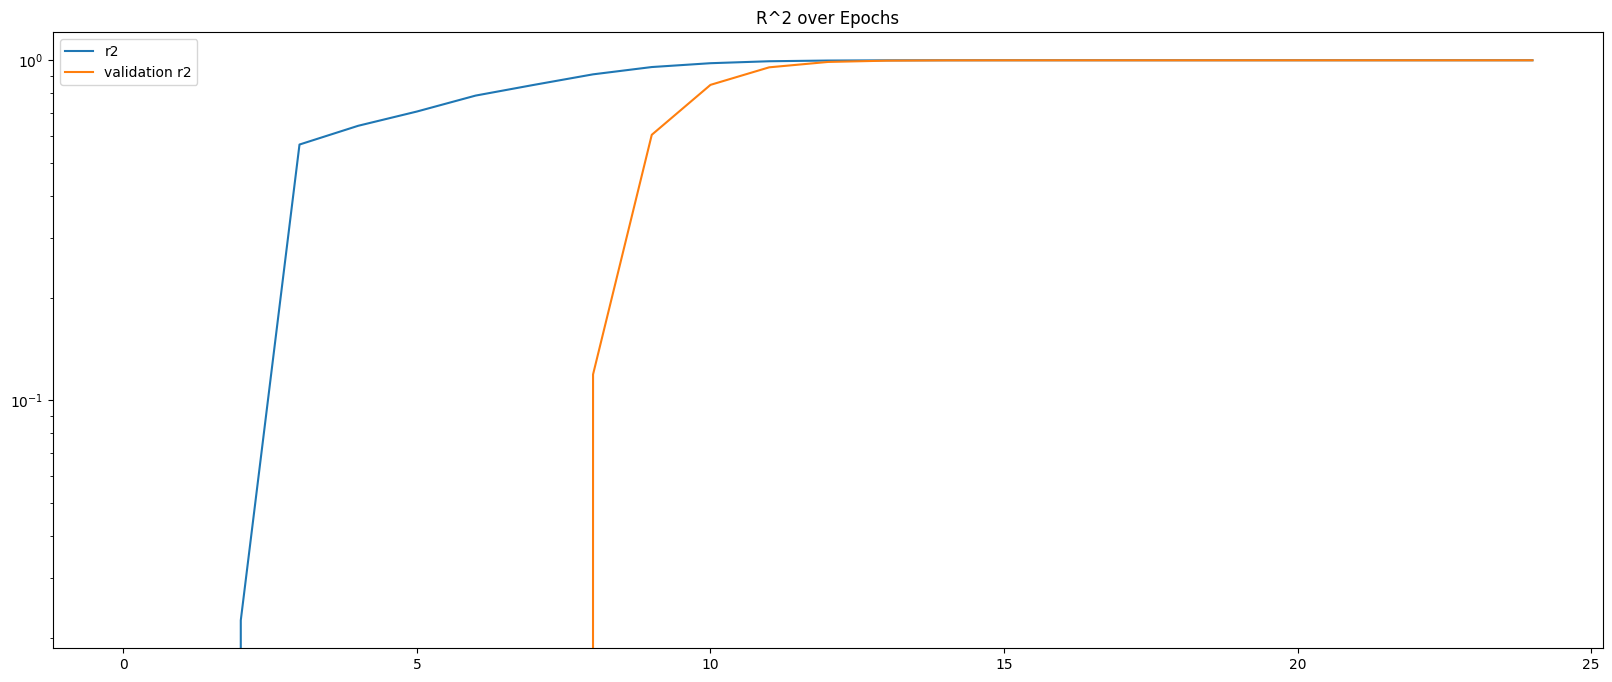

In [175]:
plt.yscale('log')
plt.plot(history.history['r2_metric'])
plt.plot(history.history['val_r2_metric'])
plt.title('R^2 over Epochs')

plt.legend(['r2', 'validation r2']);

In [176]:
model.evaluate(X, Y, batch_size=batch_size, verbose=0)




ValueError: ignored

### R2 for all data

In [160]:
from sklearn.metrics import r2_score

Y_pred = model.predict(X)
r2_score(Y, Y_pred)


KeyboardInterrupt



### R2 for training data

In [102]:
Y_train_pred = model.predict(X_train)
r2_score(Y_train, Y_train_pred)

112/112 [==============================] - 0s 4ms/step


0.6558229578244475

### R2 for validation data

In [103]:
Y_test_pred = model.predict(X_test)
r2_score(Y_test, Y_test_pred)

12/12 [==============================] - 0s 4ms/step


-0.31080672562838085

## Let's plot predicted and true over each other

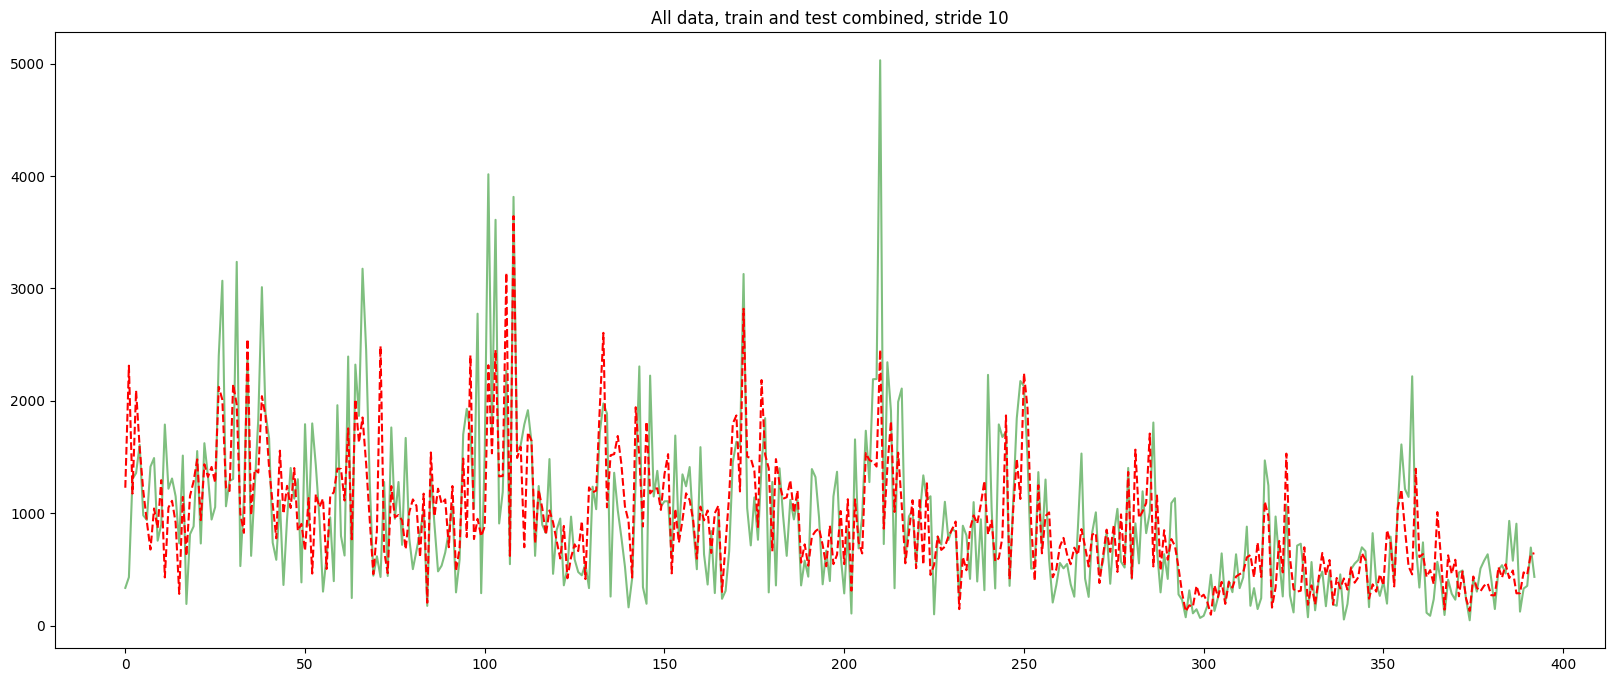

In [66]:
# this gets really crowded, using a stride, makes it more readable
stride = 10

# for the first 90 days we have no prediction, so get rid of them
plt.plot(NO[n_steps_in::stride], alpha=0.5, color='g')
plt.plot(Y_pred[::stride], color='r', ls='dashed')

plt.title('All data, train and test combined, stride 10');


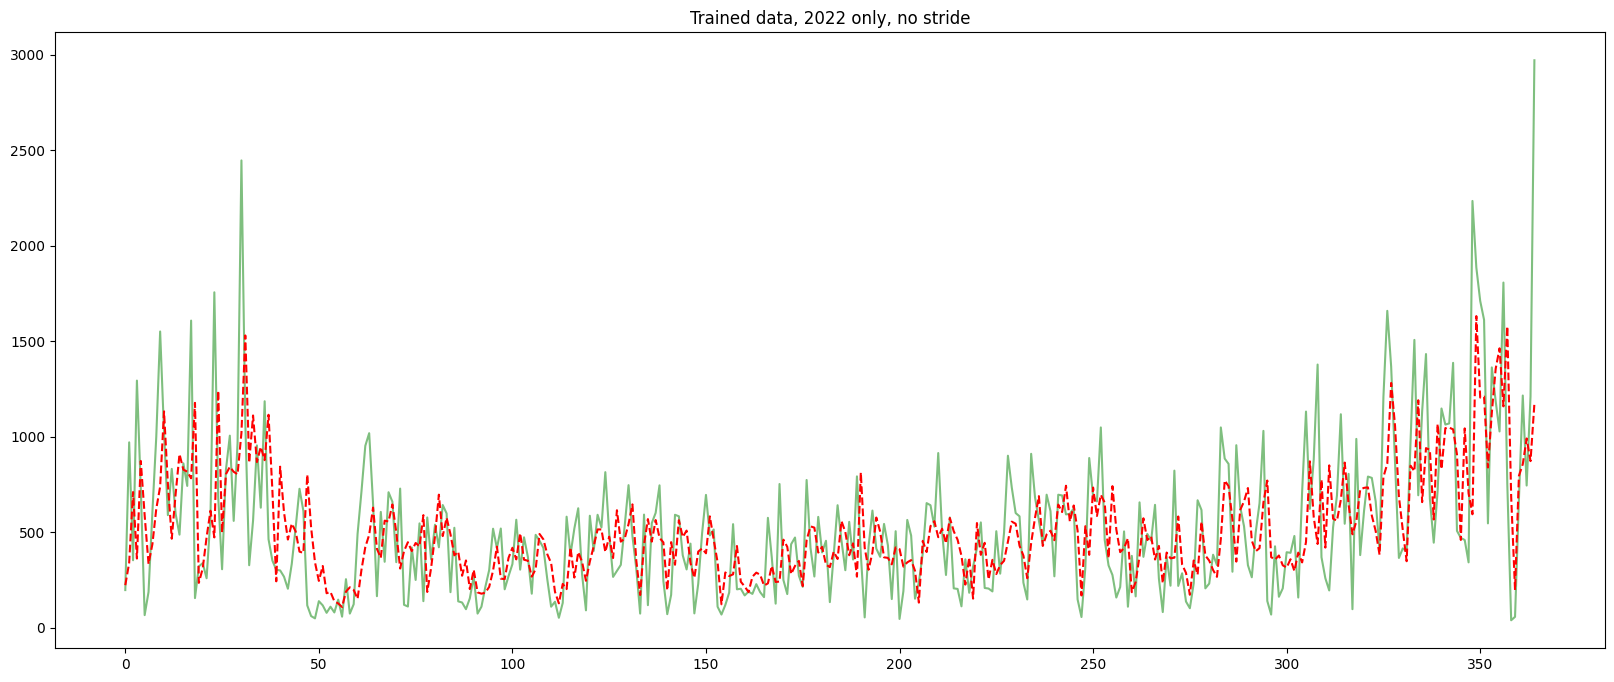

In [68]:
stride = 1


plt.plot(NO[-2 * 365:-365:stride], alpha=0.5, color='g')
plt.plot(Y_train_pred[-365::stride], color='r', ls='dashed')

plt.title('Trained data, 2022 only, no stride');


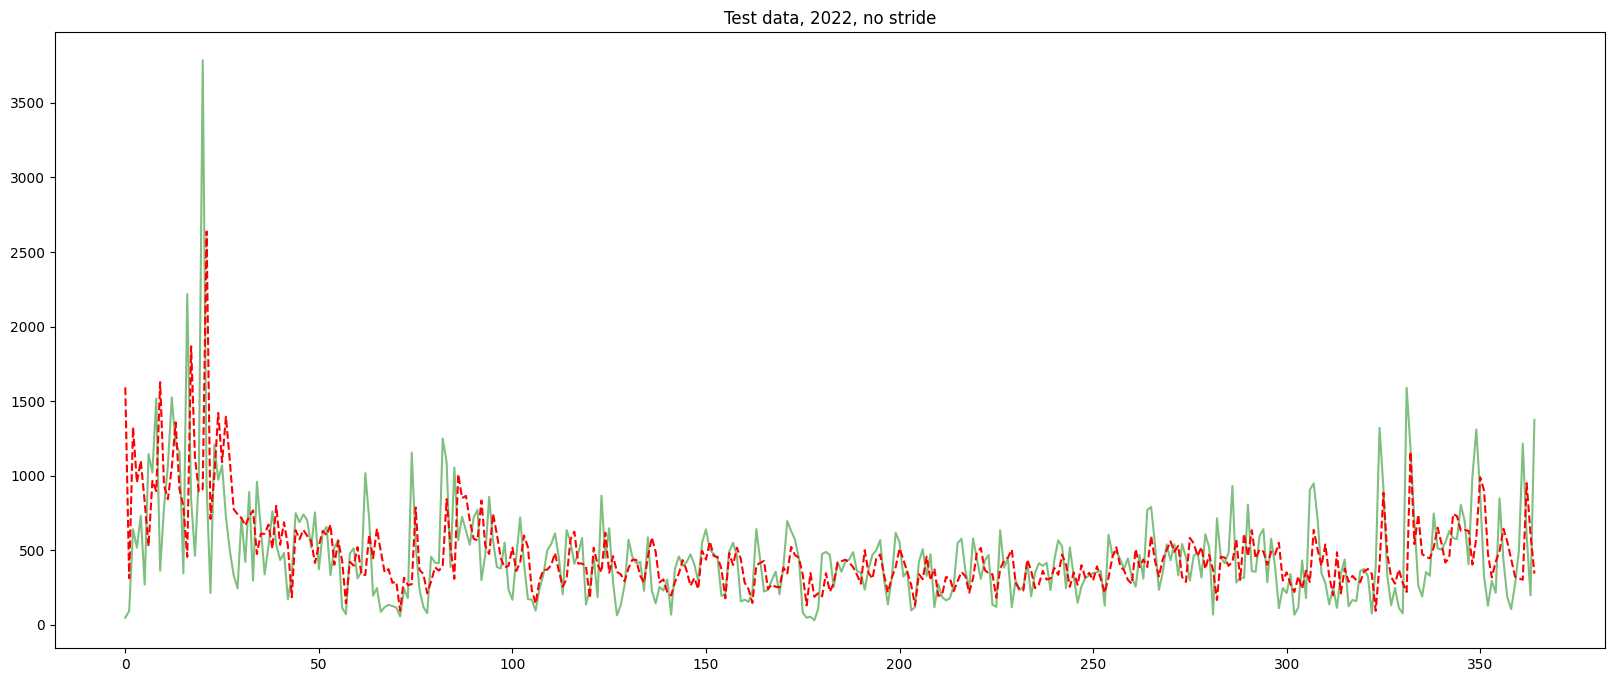

In [69]:
stride = 1


plt.plot(NO[-365::stride], alpha=0.5, color='g')
plt.plot(Y_test_pred[::stride], color='r', ls='dashed')

plt.title('Test data, 2022, no stride');


## Observation / Wrap-Up

### overall a pretty good result
* r2 score is pretty promising
* defintely improved over baseline
* no domain knowledge necessary

### no dramatic difference between training and test data
* neither in metrices
* nor in visual inspection

### peaks and valleys are underestimated very often
* but often the most interesting part
* this seems to be a common problem in time series prediction
* it gets better we train the model for longer
* also when we increase its capacity
* on the other hand this might counter regularization


## Next Steps
  
### make use of seasonal decomposition
* predict each of the components
  * trend should be pretty easy
  * residual shows clear spices on national holidays
  * remove them
  * the results might be noise only
  * but maybe it is not, train a model on it to check
  
### have a more powerful statistical baseline
* Use more powerful statistical models
  * https://www.statsmodels.org/stable/tsa.html
  * http://www.statsmodels.org/dev/tsa.html
  * http://www.statsmodels.org/dev/vector_ar.html
* MSBVAR (Markov-Switching, Bayesian, Vector Autoregression Models) might beat our model, but
  * needs a lot of modelling
  * does not seem readily available in the Python world (in R it would be)
  
